This is the data chanlendge form Delointte to design a machine learning approach to predict binding between protein/molecule pairs based on Kinase Inhibitor BioActivity (KIBA) dataset
1. A list of UniProt IDs & PubChem IDs has been provided for pairs with confirmed binding affinity.
2. You may only use these proteins and chemicals in designing your model (though you can create permutations of the pairs to generate synthetic negative examples).
3. The kiba_score_estimated column will be True if a KIBA score in that row is estimated, or False if directly calculated using the standard Kd, Ki, and IC50 scores.  
4. Leverage the provided data or collect any additional outside data relating to the provided proteins & chemicals as that may be needed to improve your model’s performance, if applicable.
5. Your model will be evaluated on a held-out test set; please provide any reproducible code that we can use to pull additional outside data for our test set.
6. You are welcome to use any open-source libraries/packages/resources but keep in mind to include the details of what is going on ‘under the hood’ in your summary and analysis.
7. For any auxiliary datasets as part of your solution, if applicable, please provide references and relevant python code/functions so that we can pull in the same data for review

## Load libraries

In [2]:
#from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import warnings
import sklearn
import pickle
import scipy
import numpy
import json
import sys
import csv
import os

print('matplotlib: {}'.format(matplotlib.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('scipy: {}'.format(scipy.__version__))
print('seaborn: {}'.format(sns.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))

warnings.filterwarnings('ignore')
sns.set(color_codes=True)
plt.style.available

%matplotlib inline
%precision 2

if sys.version_info[0:2] != (3, 10):
    raise Exception('May require python 3.10 for installing ProtEnc library')

matplotlib: 3.9.2
sklearn: 1.5.2
scipy: 1.13.1
seaborn: 0.13.2
pandas: 2.2.3
numpy: 1.26.4
Python: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]


In [18]:
## ML libraries
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, confusion_matrix, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import sklearn.metrics as metrics
import xgboost

## libaries for data retrieval, embedding
from scikit_mol.fingerprints import RDKitFingerprintTransformer
from rdkit import Chem
from Bio import SeqIO
from Bio import ExPASy
import pubchempy as pcp
import protenc

## Custom functions

In [6]:
## functions for retrieval, embedding, integration

def get_uniprot_data(ids):
    """
    Retrieves UniProt name, description sequence for a given UniProt ID list.
    
    Args:
        list of ids

    Returns:
        pd.DataFrame: A DataFrame containing the required fields (hard coded now)
    """

    ## create empty data frame
    protein_df = pd.DataFrame(columns=['UniProt_ID', 'Name', 'Desc', 'Seq'])

    for id in ids:
        with ExPASy.get_sprot_raw(id) as handle:
            record = SeqIO.read(handle, "swiss")
            #ref = record.dbxrefs
            this_entry = {'UniProt_ID': id, 
                          'Name': record.name, 
                          'Desc': record.description, 
                          'Seq': str(record.seq) }
        ## add new row to df
        protein_df = pd.concat([protein_df, pd.DataFrame([this_entry])], ignore_index=True)

    return protein_df


def get_protein_embedding(proteins, encoder = "esm2_t12_35M_UR50D"):
    """
    Transform protein sequence into enbeddings.
    
    Args:
        list of protein sequence 

    Returns:
        list of embeddings
    """
    
    ## reasonable size, still have issue, may need to break into several sections to run
    encoder = protenc.get_encoder(encoder)

    ## have to run twice to finish the encoding
    print(f'Get embedding for {len(proteins)} sequences with encoder: {encoder}')
    prot_embed = []
    
    ## failed with memory error when use large embedding
    for embed in encoder(proteins, return_format='numpy'):
        # Embeddings have shape [L, D] where L is the sequence length and D the  embedding dimensionality.
        print(embed.shape)
      
        # Derive a single per-protein embedding vector by averaging along the sequence dimension
        prot_embed.append(embed.mean(0))

    return prot_embed


def get_pubchem_data(ids):
    """
    Retrieves chemical properties from pubchem, the returned results already in data frame
        
    Args:
        list of ids

    Returns:
        pd.DataFrame: A DataFrame containing the required fields (hard coded now)

    """
    
    ## must change ids to list, CanonicalSMILES
    chem_df = pcp.get_properties(['isomeric_smiles', 'molecular_weight', 'xlogp', 'TPSA', 'Charge', 'CovalentUnitCount', 'rotatable_bond_count'], 
                                 identifier=ids, 
                                 namespace='cid', 
                                 as_dataframe=True)

    return chem_df


def get_compound_embedding(smiles_strings):
    """
    Transform smile strings into enbeddings.
    
    Args:
        list of smile strings 

    Returns:
        list of embeddings
    """
    
    # import an RDKit fingerprint transformer
    transformer = RDKitFingerprintTransformer(maxPath=5, fpSize=128)
    #print(transformer)
    
    # get smile string from our compound list
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_strings]
    
    ## fps is numpy array
    fps = transformer.transform(mols)

    return fps.tolist()


In [8]:
## for categorical value, also show the percentage of the most dominate values
def get_table_summary(df):
    """
    Gets a summary of a pandas DataFrame, including column type, mean, median, missing values, and unique values.

    Args:
        df (pd.DataFrame): The DataFrame to summarize.

    Returns:
        pd.DataFrame: A DataFrame containing the summary information.
    """

    summary = pd.DataFrame(columns=['Column', 'Type', 'Mean', 'Median', 'STD', 'Unique Values', 'Missing Values'])
    
    for col in df.columns:
        tmp_dict = {
            'Column': col,
            'Type': df[col].dtype,
            'Mean': df[col].mean() if pd.api.types.is_numeric_dtype(df[col]) else 'N/A',
            'Median': df[col].median() if pd.api.types.is_numeric_dtype(df[col]) else 'N/A',
            'STD': df[col].std() if pd.api.types.is_numeric_dtype(df[col]) else 'N/A',
            'Unique Values': df[col].nunique(),
            'Missing Values': df[col].isnull().sum(),
        }
        summary = pd.concat([summary, pd.DataFrame(tmp_dict, index=[0])], ignore_index=True)

    ## add missing percentage
    summary['Missing Percent'] = np.round(summary['Missing Values'] * 100 / len(df), 3)
    
    return summary


## report error of regression model
def regression_report(y_true, y_pred):
    """
    Report several metrics for regression problems.

    Args:
        ground truth, predicted values

    Returns:
        none, just print
    """
    
    error = y_true - y_pred
    percentil = [5,25,50,75,95]
    percentil_value = np.percentile(error, percentil)
    
    my_metrics = [
        ('mean absolute error', metrics.mean_absolute_error(y_true, y_pred)),
        ('median absolute error', metrics.median_absolute_error(y_true, y_pred)),
        ('mean squared error', metrics.mean_squared_error(y_true, y_pred)),
        ('max error', metrics.max_error(y_true, y_pred)),
        ('r2 score', metrics.r2_score(y_true, y_pred)),
    ]
    
    print('Metrics for regression:')
    for metric_name, metric_value in my_metrics:
        print(f'{metric_name:>25s}: {metric_value: >20.3f}')
        
    print('\nPercentiles of error (y_true - y_pred):')
    for p, pv in zip(percentil, percentil_value):
        print(f'{p: 25d}: {pv:>20.3f}')

In [8]:
# Global variables
raw_dir = "C:/Users/cloud/Documents/programming/python/datasets/"
dat_dir = "data/"
out_dir = "output/"
mod_dir = "model/"

## 1. Extract subsets and retrieve extra data

In [27]:
## read in target-compound pairs
df = pd.read_csv(raw_dir + "Deloitte_DrugDiscovery_dataset.csv")

print(df.shape)
df.head(2)

(1134638, 4)


,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated
0,A0A0B4J268,7428.0,21400.0,True
1,A0A0B4J268,65303.0,21300.0,True


### 1.1 Filtering and subsets

In [29]:
## remove duplicates, need to do this again later after cleaning the data
duplicate = df.duplicated()
print(duplicate.sum())
df.drop_duplicates(inplace=True)
print(df.shape)

21816
(1112822, 4)


In [21]:
## quick summary of the table
summary_df = get_table_summary(df)
summary_df

,Column,Type,Mean,Median,STD,Unique Values,Missing Values,Missing Percent
0,UniProt_ID,object,N/A,N/A,N/A,4480,0,0.0
1,pubchem_cid,float64,67044638.155416,57393578.5,49324561.91226,683413,9580,0.860874
2,kiba_score,float64,25332.065603,175.0,1355406.331745,7722,27329,2.455829
3,kiba_score_estimated,object,N/A,N/A,N/A,2,27329,2.455829


In [31]:
# all pair are missing kiba score and estimated flag at the same time, so remove all rows with missing values
#sub_df = df.loc[df['kiba_score_estimated'].isna(), ]
#get_table_summary(sub_df)

# drop all rows with any missing values
df.dropna(inplace=True)

## convert pubchem_cid to integer as query with float won't work
df['pubchem_cid'] = df['pubchem_cid'].astype(int)

## log transformation on target varaible, distribution also looks more normal in log
df['log_kiba_score'] = np.log(df['kiba_score'])

print(df.shape)

(1075947, 5)


kiba_score_estimated
True     1046236
False      29711
Name: count, dtype: int64


<Axes: title={'center': 'All KiBA score'}, xlabel='log_kiba_score', ylabel='Count'>

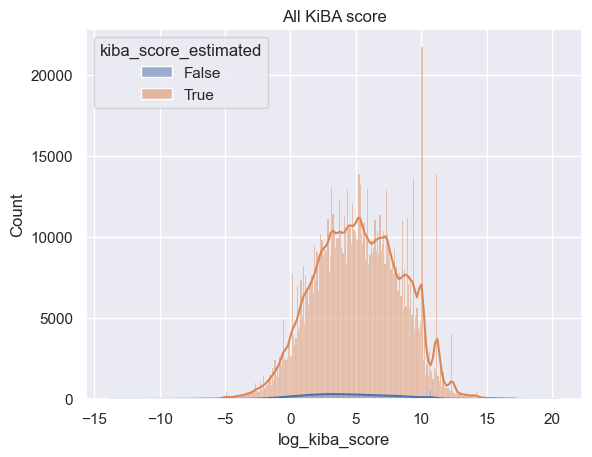

In [40]:
## should estimated score be treated differently?
print(df['kiba_score_estimated'].value_counts())

## overall distribution, there are some clusters of same values
plt.title("All KiBA score");
sns.histplot(df, x='log_kiba_score', kde=True, hue='kiba_score_estimated')

#### Extract 1st subset with Kiba value not estimated (by experiment), thus with higher quality?

In [45]:
## Take the subset with kiba_score is not estimated.
kiba_exp_df = df.loc[df['kiba_score_estimated'] == False, ]
print(kiba_exp_df.shape)

## unique protein and compound in this set.
kiba_pubchem_ids = kiba_exp_df['pubchem_cid'].unique()
kiba_uniprot_ids = kiba_exp_df['UniProt_ID'].unique()

print(len(kiba_pubchem_ids))
print(len(kiba_uniprot_ids))

(29711, 5)
21805
1370


Text(0.5, 1.0, 'KiBA score not estimated')

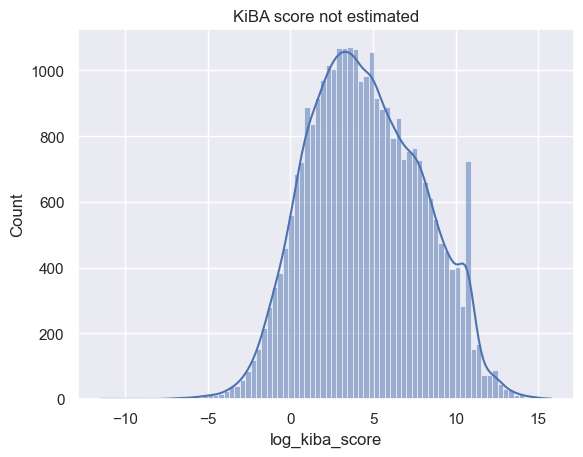

In [47]:
## score distribution in the 1st subset
sns.histplot(data=kiba_exp_df, x='log_kiba_score', kde=True);
plt.title("KiBA score not estimated")

#### Extract 2nd subset: proteins and compounds pairs with most interactions

In [53]:
## remove compounds with low interacting proteins
pubchem_count = df['pubchem_cid'].value_counts()
print("Unique compound:", str(len(pubchem_count)))

pubchem_ids = pubchem_count[pubchem_count > 4].index
print("Unique compound with interactions > 4:", str(len(pubchem_ids)))

## filter the table with compounds interactions > 4
active_df = df.loc[df['pubchem_cid'].isin(pubchem_ids),]
print(df.shape, active_df.shape)

Unique compound: 665492
Unique compound with interactions > 4: 17228
(1075947, 5) (144763, 5)


In [55]:
## remove proteins with low interacting compounds 
uniprot_count = active_df['UniProt_ID'].value_counts()
print("Unique uniprot:", str(len(uniprot_count)))

uniprot_ids = uniprot_count[uniprot_count > 9].index
print("Unique uniprot with > 9 interactions:", str(len(uniprot_ids)))

active_df = active_df.loc[df['UniProt_ID'].isin(uniprot_ids),]

## size reduced to 139516 pairs
print(active_df.shape)

Unique uniprot: 2992
Unique uniprot with > 9 interactions: 1232
(139516, 5)


In [40]:
## check the number of compound each proteins binds to
#sns.countplot(x='UniProt_ID', data=df, order=counts.index,  hue="kiba_score_estimated")
#plt.xticks([])
#plt.show()

<Axes: title={'center': 'KiBA score in highly interacting subset'}, xlabel='log_kiba_score', ylabel='Count'>

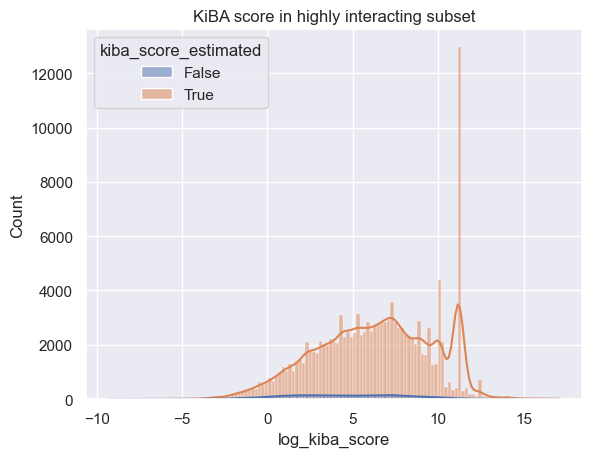

In [57]:
# why there is big bar around score 11? Should those be removed
print(active_df['kiba_score_estimated'].value_counts())

plt.title("KiBA score distribution in highly interacting subset");
sns.histplot(active_df, x='log_kiba_score', kde=True, hue='kiba_score_estimated')

In [89]:
## there are some peak values: kiba score at 72000/11.18, and 22500/10.02 
active_df['kiba_score'].value_counts().head(10)

kiba_score
72000.00     12674
22500.00      3717
12100.00      1508
29200.00      1434
7610.00       1346
80.50         1084
1500.00        722
234000.00      615
9.73           565
22.60          563
Name: count, dtype: int64

In [52]:
## is estimated and actual kiba score significantly different? T-test?
grouped = active_df.groupby('kiba_score_estimated')['log_kiba_score']

# Perform the t-test, those are significantly different
t_stat, p_value = ttest_ind(grouped.get_group(True), grouped.get_group(False))
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 40.02940015220634
P-value: 0.0


### 1.2 Get data from Uniprot and Pubchem
1. for 1st subset, sequence embedding failed with memory errors, thus not used for modeling
2. for 2nd subset with highly interacting proteins, it worked fine

#### Uniprot

In [342]:
%%time
## 43min 28s for 1768 proteins
protein_df = get_uniprot_data(missing_prot)
print(protein_df.shape)
display(protein_df.head())

(358, 4)


,UniProt_ID,Name,Desc,Seq
0,A5GZW8,DHSD_PIG,RecName: Full=Succinate dehydrogenase [ubiquin...,MATLWRLSVLCGARGGGALVLRTSVVRPAHVSAFLQDRHTPGWCGV...
1,D0VWV4,C560_PIG,RecName: Full=Succinate dehydrogenase cytochro...,MAALLLRHVGRHCLRAHLSPQLCIRNAVPLGTTAKEEMERFWNKNL...
2,E9QYP0,SIDA_ASPFU,RecName: Full=L-ornithine N(5)-monooxygenase {...,MESVERKSESSYLGMRNMQPEQRLSLDPPRLRSTPQDELHDLLCVG...
3,H9TB17,AOXA_CAVPO,RecName: Full=Aldehyde oxidase 1 {ECO:0000250|...,MEPSTLYFYVNGRRVTEKNVDPETMLLPYLGRNLRLTGTKYGCGGG...
4,K4CF70,HPL_SOLLC,"RecName: Full=Fatty acid hydroperoxide lyase, ...",MNSAPLSTPAPVTLPVRSIPGSYGLPLVGPIADRLDYFWFQKPENF...


CPU times: total: 1min 28s
Wall time: 11min 10s


In [77]:
# # now compare with multi interaction file
# multi_df = pd.read_csv(dat_dir + "Uniprot_multi_interaction.tsv", sep="\t")
# print(multi_df.shape)
# # get proteins not in multi file

# missing_prot_df = kiba_protein_df.loc[~kiba_protein_df['UniProt_ID'].isin(multi_df['UniProt_ID']),]
# proteins = missing_prot_df['Seq'].tolist()
# print(missing_prot_df.shape)
# print(len(proteins))

In [16]:
# List available models in protenc. 
# Create embedding for one sequence is usually OK, but running a list will have memory issues
# esm2_t12_35M_UR50D: 2nd smallest, still crashed when creating 1 dataset
# esm2_t30_150M_UR50D: vector length 640, memory issue
# esm2_t36_3B_UR50D: vector size 2560. SOTA general-purpose protein language model.

print(protenc.list_models())

['prot_t5_xl_uniref50', 'prot_t5_xl_bfd', 'prot_t5_xxl_uniref50', 'prot_t5_xxl_bfd', 'prot_bert_bfd', 'prot_bert', 'esm2_t48_15B_UR50D', 'esm2_t36_3B_UR50D', 'esm2_t33_650M_UR50D', 'esm2_t30_150M_UR50D', 'esm2_t12_35M_UR50D', 'esm2_t6_8M_UR50D']


In [ ]:
%%time
# Wall time: 1h 45min 39s
# Load encoder model

# reasonable size, still have issue
encoder = protenc.get_encoder('esm2_t12_35M_UR50D')

# have to run twice to finish the encoding
#proteins = protein_df['Seq'].tolist()
print(len(proteins))
prot_embed = []

# failed with memory error when use large embedding
for embed in encoder(proteins, return_format='numpy'):
    # Embeddings have shape [L, D] where L is the sequence length and D the  embedding dimensionality.
    print(embed.shape)
  
    # Derive a single per-protein embedding vector by averaging along the sequence dimension
    prot_embed.append(embed.mean(0))

print(len(prot_embed))

In [132]:
print(len(prot_embed))
print(protein_df.shape)

# add embedding back to the df
protein_df['seq_embed'] = prot_embed
display(protein_df.head(2))
display(protein_df.tail(2))

1232
(1232, 4)


,UniProt_ID,Name,Desc,Seq,seq_embed
0,P00918,CAH2_HUMAN,RecName: Full=Carbonic anhydrase 2; EC=4.2.1.1...,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,"[-0.16656972, 0.008713209, 0.11217784, 0.37478..."
1,P00915,CAH1_HUMAN,RecName: Full=Carbonic anhydrase 1; EC=4.2.1.1...,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,"[-0.1423874, 0.036990207, 0.09843322, 0.335536..."


,UniProt_ID,Name,Desc,Seq,seq_embed
1756,Q9NRX3,NUA4L_HUMAN,RecName: Full=NADH dehydrogenase [ubiquinone] ...,MAGASLGARFYRQIKRHPGIIPMIGLICLGMGSAALYLLRLALRSP...,"[-0.092301905, -0.124588035, 0.08781392, -0.03..."
1759,P03915,NU5M_HUMAN,RecName: Full=NADH-ubiquinone oxidoreductase c...,MTMHTTMTTLTLTSLIPPILTTLVNPNKKNSYPHYVKSIVASTFII...,"[-0.17527467, -0.09168148, 0.054699544, 0.1814..."


In [72]:
# load compound file
protein_file = out_dir + "Uniprot_multi_interaction.tsv"
protein_df = None

## save or load the data file
if not os.path.exists(protein_file):
    ## save data to file, in case crash due to memory
    protein_df.to_csv(protein_file, index=False, sep="\t")
else:
    ## load protein data for further processing
    protein_df = pd.read_csv(protein_file, sep="\t")
    ## when read from file, pandas treat the array as object, use eval to make it array
    protein_df['seq_embed'] = protein_df['seq_embed'].apply(eval)

print(protein_df.shape)
protein_df.head(2)

(1768, 4)


,UniProt_ID,Name,Desc,Seq
0,P00918,CAH2_HUMAN,RecName: Full=Carbonic anhydrase 2; EC=4.2.1.1...,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...
1,P00915,CAH1_HUMAN,RecName: Full=Carbonic anhydrase 1; EC=4.2.1.1...,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...


#### Pubchem

In [190]:
%%time
## time out error first time, 2nd time OK
print(len(pubchem_ids))

chem_df = get_pubchem_data(pubchem_ids.tolist())

# CID was used as index here
print(chem_df.shape)
display(chem_df.head())

35124
(35124, 7)


,MolecularWeight,IsomericSMILES,XLogP,TPSA,Charge,RotatableBondCount,CovalentUnitCount
CID,,,,,,,
44259,466.5,C[C@@]12[C@@H]([C@@H](C[C@@H](O1)N3C4=CC=CC=C4...,3.2,69.4,0,2,1
135423438,539.6,CN1CCN(CC1)CC(=O)N(C)C2=CC=C(C=C2)N=C(C3=CC=CC...,4.3,102.0,0,8,1
5494449,464.6,CC1=CC(=NN1)NC2=CC(=NC(=N2)SC3=CC=C(C=C3)NC(=O...,3.4,127.0,0,7,1
176155,377.4,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...,3.2,77.8,0,4,1
135565635,308.34,CC(C)N1C2=NC=NC(=C2C(=N1)C3=CC4=C(N3)C=CC(=C4)O)N,2.0,106.0,0,2,1


CPU times: total: 188 ms
Wall time: 14.4 s


In [192]:
%%time
#smiles_strings = ["c1ccccc1", "Cc1ccncc1CCCN", "Cc1ccncc1CN"]

# import an RDKit fingerprint transformer
# I selected vector size to be 128, it could be smaller, maybe 96
transformer = RDKitFingerprintTransformer(maxPath=5, fpSize=128)
#print(transformer)

# get smile string from our compound list
smiles_strings = chem_df['IsomericSMILES']
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_strings]

## fps is numpy array
fps = transformer.transform(mols)
print(f"{fps.__class__=}")
print(f"{fps.shape=}")

chem_df['comp_embed'] = fps.tolist()
chem_df.head(2)

RDKitFingerprintTransformer(fpSize=128, maxPath=5)
fps.__class__=<class 'numpy.ndarray'>
fps.shape=(35124, 128)
CPU times: total: 13.1 s
Wall time: 24 s


In [172]:
# load compound file
compound_file = out_dir + "Pubchem.tsv"

if not os.path.exists(compound_file):
    ## save data to file
    chem_df.to_csv(compound_file, index=True, sep="\t")
    print("ouput compound data")
else:
    ## load data for further processing
    print("load compound data")
    chem_df = pd.read_csv(compound_file, sep="\t")
    chem_df.set_index("CID", inplace=True)
    ## when read from file, pandas treat the array as object, use eval
    chem_df['comp_embed'] = chem_df['comp_embed'].apply(eval)

print(chem_df.shape)
chem_df.head(2)

load compound data
(35124, 8)


,MolecularWeight,IsomericSMILES,XLogP,TPSA,Charge,RotatableBondCount,CovalentUnitCount,comp_embed
CID,,,,,,,,
44259,466.5,C[C@@]12[C@@H]([C@@H](C[C@@H](O1)N3C4=CC=CC=C4...,3.2,69.4,0,2,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
135423438,539.6,CN1CCN(CC1)CC(=O)N(C)C2=CC=C(C=C2)N=C(C3=CC=CC...,4.3,102.0,0,8,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."


In [ ]:
#alternative method for embeding
from rdkit.Chem import RDKFingerprint

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fingerprint = RDKFingerprint(mol)
    return fingerprint

smiles_string = "CC(=O)Oc1ccccc1C(=O)O"
fingerprint = smiles_to_fingerprint(smiles_string)

print(fingerprint.ToBitString())

### 1.3 Merging target and drug embeddings

In [158]:
## protein enbedding
## somehow, use UniProt_ID as index makes other columns NA? so set it as index first
protein_df.set_index('UniProt_ID', inplace=True)
prot_embed_df = pd.DataFrame(protein_df['seq_embed'].tolist(), index=protein_df.index)
prot_embed_df = prot_embed_df.add_prefix('seq')
print(prot_embed_df.shape)
prot_embed_df.head()

(1232, 480)


,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8,seq9,...,seq470,seq471,seq472,seq473,seq474,seq475,seq476,seq477,seq478,seq479
UniProt_ID,,,,,,,,,,,,,,,,,,,,,
P00918,-0.166570,0.008713,0.112178,0.374787,0.100729,0.002372,-0.044080,0.107390,-0.223638,0.011553,...,0.131383,-0.249097,-0.102665,0.119280,0.087670,0.205653,0.021233,0.069158,0.006577,-0.007266
P00915,-0.142387,0.036990,0.098433,0.335537,0.128231,-0.011551,-0.045341,0.131750,-0.202016,-0.010990,...,0.149635,-0.212050,-0.092108,0.104383,0.068956,0.253252,0.064376,0.037062,-0.006947,0.021708
Q16790,-0.138583,0.015195,0.011749,0.278092,-0.010051,-0.023715,0.182716,0.115429,0.109035,-0.146339,...,-0.124855,-0.278662,-0.007802,0.050195,0.039957,-0.022215,0.219743,0.056104,-0.099055,-0.083136
P41143,-0.106430,-0.051287,-0.048329,0.155615,0.091155,-0.058298,-0.078063,-0.044302,0.003188,-0.019884,...,0.030794,-0.159346,-0.049608,0.048558,-0.194122,-0.080134,0.116155,-0.020994,-0.134889,-0.031779
P35968,-0.000959,0.082399,0.052746,0.125576,0.034335,0.052178,-0.028555,0.082923,-0.044801,0.031012,...,0.019519,-0.028747,0.076194,0.053000,0.000584,-0.105360,0.054952,0.011981,-0.043855,0.121176


In [208]:
#embed_stats_df = get_table_summary(prot_embed_df)
#embed_stats_df
prot_embed_df.describe()

,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8,seq9,...,seq470,seq471,seq472,seq473,seq474,seq475,seq476,seq477,seq478,seq479
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,...,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,-0.058946,-0.010868,0.031622,0.081346,0.002738,-0.036141,0.006669,0.049609,-0.042511,-0.002304,...,0.013379,-0.037627,0.063667,0.071212,-0.066877,-0.087487,0.048185,-0.034114,-0.072187,0.031883
std,0.063684,0.065444,0.059834,0.096098,0.068521,0.068308,0.089682,0.066427,0.082073,0.061828,...,0.068607,0.088316,0.079252,0.062185,0.080351,0.071153,0.088850,0.055655,0.074386,0.068523
min,-0.256726,-0.341380,-0.221685,-0.292898,-0.211331,-0.282100,-0.278720,-0.205457,-0.283023,-0.209289,...,-0.257756,-0.335175,-0.241956,-0.114789,-0.276284,-0.432494,-0.252476,-0.418753,-0.283591,-0.320656
25%,-0.101746,-0.048439,-0.006096,0.028227,-0.042368,-0.082381,-0.050857,0.009657,-0.103306,-0.045066,...,-0.028350,-0.095795,0.012070,0.031737,-0.128400,-0.130717,-0.014001,-0.066268,-0.122869,-0.010701
50%,-0.058797,-0.006321,0.033975,0.081657,0.003996,-0.033604,-0.004673,0.050306,-0.040526,-0.000419,...,0.015491,-0.031213,0.066959,0.071672,-0.070971,-0.096128,0.033052,-0.032060,-0.077699,0.036624
75%,-0.019266,0.035024,0.070655,0.133111,0.052500,0.009400,0.062846,0.090729,0.016215,0.041112,...,0.058631,0.023433,0.117958,0.111755,-0.018643,-0.052808,0.107157,0.000494,-0.023887,0.075239
max,0.185956,0.160022,0.314507,0.423303,0.179353,0.158625,0.343412,0.273547,0.259457,0.191276,...,0.250302,0.261717,0.317855,0.304292,0.251031,0.260904,0.284182,0.202431,0.234355,0.264939


In [198]:
## compound embedding
chem_embed_df = pd.DataFrame(chem_df['comp_embed'].tolist(), index=chem_df.index)
chem_embed_df = chem_embed_df.add_prefix('smile')
print(chem_embed_df.shape)
chem_embed_df.head(2)

(35124, 128)


,smile0,smile1,smile2,smile3,smile4,smile5,smile6,smile7,smile8,smile9,...,smile118,smile119,smile120,smile121,smile122,smile123,smile124,smile125,smile126,smile127
CID,,,,,,,,,,,,,,,,,,,,,
44259,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
135423438,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [200]:
## adding other compound properties to the bit strings, but normalize first
#active_df.drop(['kiba_score', 'kiba_score_estimated'], axis=1, inplace=True) 	
#active_df.head()
print(active_df.shape)

## merge protein embedding
train_df = active_df.merge(prot_embed_df, left_on = 'UniProt_ID', right_index = True, how='inner')
print(train_df.shape)

## merge compound embedding
train_df = train_df.merge(chem_embed_df, left_on = 'pubchem_cid', right_index = True, how='inner')
print(train_df.shape)

train_df.head()

(139516, 3)
(139516, 483)
(139516, 611)


,UniProt_ID,pubchem_cid,log_kiba_score,seq0,seq1,seq2,seq3,seq4,seq5,seq6,...,smile118,smile119,smile120,smile121,smile122,smile123,smile124,smile125,smile126,smile127
2,A0A0B4J268,96506,9.971146,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,0,1,1,1,1,0
4,A0A0B4J268,225906,8.975883,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,1,1,1,1,1,1
10,A0A0B4J268,440990,9.966462,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,0,1,0,1,1,1,1,1,1
14,A0A0B4J268,665183,9.966462,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,1,1,1,1,1,0
19,A0A0B4J268,704725,8.055158,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,1,1,1,1,1,1


In [151]:
## output data for later use
#train_df.to_csv(dat_dir + "embedding_only.csv", index=False)

train_df = pd.read_csv(dat_dir + "embedding_only.csv", index_col=0)
print(train_df.shape)
train_df.head()

(139516, 611)


,UniProt_ID,pubchem_cid,log_kiba_score,seq0,seq1,seq2,seq3,seq4,seq5,seq6,...,smile118,smile119,smile120,smile121,smile122,smile123,smile124,smile125,smile126,smile127
2,A0A0B4J268,96506,9.971146,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,0,1,1,1,1,0
4,A0A0B4J268,225906,8.975883,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,1,1,1,1,1,1
10,A0A0B4J268,440990,9.966462,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,0,1,0,1,1,1,1,1,1
14,A0A0B4J268,665183,9.966462,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,1,1,1,1,1,0
19,A0A0B4J268,704725,8.055158,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,...,1,1,1,1,1,1,1,1,1,1


## 2. EDA 
remove feature if not useful, data cleaning will be done in next step
1. Identify ID features (or other features with very high cardinality), set as index or drop those.
2. Do numeric features needs to be normalized, depends on the model (for RF, no; clustering, yes)
3. Missing values: remove features with missing percent >= 75% (or 50%), otherwise imputer.
4. Impute: mumeric values with median, categorical values with mode (or "Unknown")
5. Dates values, are those needed? convert to year, month, or by distance to a certain point in time.
6. Check cardinality of categorical values, if > sqrt(n), need to collapse low count features into one group as "Others"
7. Check whether categorical values are dominated by one value, providing less info.

In [ ]:
## use ydata for autoEDA, is setting interactions.targets to target var only?
profile = ProfileReport(train_df, title="report", explorative=True)

## profile.to_notebook_iframe()
#profile.to_widgets()

## for messy data, output to html can avoid errors when displaying within notebook
profile.to_file("embedding_report.html")

### 1.1 Drop useless features: ID (may use as index) or constant values

### 1.2 Checks target (dependant) variable
1. understand how it's generated (manually by SME, or by computer), look for system bias
2. check for balance of classes
3. check the correlation of all independant variables to this one, look out for potential data leakage when highly correlated
4. check potential labeling errors (usually not in the first round).
5. discard rows with missing values (first round, use "cleanlab" later for label checking)

In [ ]:
sns.histplot(data=active_df, x=target, kde=True, bins="sturges")

In [27]:
## set model type based on target type
target = 'log_kiba_score'
if df[target].dtype == 'O':
    model_type = 'classification'
else:
    model_type = 'regression'

print(model_type)
discretize_flag = False

## for classification
if model_type == 'classification':
    print(df[target].value_counts())
    sns.countplot(x=target, data=df)
    plt.title('Distribution of Target Variable')
else:
    ## took long time to draw with non log transformed value, likely due to small values.
    sns.histplot(data=df, x=target, kde=True)
    
    #skewness and kurtosis
    print("Skewness: %f" % df[target].skew())
    print("Kurtosis: %f" % df[target].kurt())

regression
Skewness: 505.578726
Kurtosis: 311197.589459


In [37]:
## subset data is more balanced
print("Skewness: %f" % active_df[target].skew())
print("Kurtosis: %f" % active_df[target].kurt())
print("Skewness: %f" % active_df['log_kiba_score'].skew())
print("Kurtosis: %f" % active_df['log_kiba_score'].kurt())
active_df.describe()

Skewness: 44.493779
Kurtosis: 2185.771410
Skewness: -0.220774
Kurtosis: -0.536396


,pubchem_cid,kiba_score,log_kiba_score
count,1.395160e+05,1.395160e+05,139516.000000
mean,4.961404e+07,3.017018e+04,6.225590
std,5.116872e+07,5.039073e+05,3.408393
min,7.000000e+00,9.270000e-05,-9.286142
25%,9.818231e+06,4.287500e+01,3.758288
50%,2.516708e+07,5.950000e+02,6.388561
75%,7.254510e+07,7.570000e+03,8.931948
max,1.651119e+08,2.700000e+07,17.111347


### 1.3 Data type conversion
1. some numeric features were treated as object due to string values entered as mistake (or combo with chars)
2. numbers with low unique value count might be categorical values
3. dates are't useful for ML, either use year/month, or time since a spefic time as numeric

### 1.4 Missing values
1. drop features with > 60% missing values (may bring some back in 2nd round)
2. replace numeric with median, and categrorical with "unknown" (unless very few)

### 1.5 More detail / visualization on certain variables

## 3. Pre-processing before modeling
not much to do here, missing value already removed, no recoding, no rescaling, no highly correlated features

In [440]:
# this section can be skipped for now
# # remove highly correlated features for regression analysis
# from feature_engine.selection import DropCorrelatedFeatures

# # no features with correlations > 0.8, no feature dropped
# print(train_df.shape)
# tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
# Xt = tr.fit_transform(train_df)
# print(Xt.shape)

In [153]:
train_df.set_index(['UniProt_ID', 'pubchem_cid'], inplace=True)
train_df.describe(include='all')

,log_kiba_score,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8,...,smile118,smile119,smile120,smile121,smile122,smile123,smile124,smile125,smile126,smile127
count,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,...,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000,139516.000000
mean,6.225590,-0.061237,0.003797,0.031490,0.095716,0.007422,-0.024762,0.002490,0.052401,-0.049983,...,0.945089,0.735113,0.978325,0.953489,0.889210,0.916268,0.931499,0.950249,0.895109,0.969473
std,3.408393,0.057731,0.058862,0.051814,0.104463,0.063404,0.061470,0.087034,0.066587,0.080199,...,0.227808,0.441275,0.145620,0.210589,0.313873,0.276987,0.252605,0.217430,0.306414,0.172033
min,-9.286142,-0.256726,-0.341380,-0.221685,-0.292898,-0.211331,-0.282100,-0.278720,-0.205457,-0.283023,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.758288,-0.098653,-0.036794,0.001407,0.037904,-0.036856,-0.060373,-0.058962,0.013152,-0.110822,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,6.388561,-0.062447,0.008061,0.036360,0.085465,0.007785,-0.023211,-0.009429,0.054881,-0.048546,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,8.931948,-0.028746,0.047689,0.062662,0.144204,0.056843,0.017518,0.053256,0.096383,0.008019,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,17.111347,0.185956,0.160022,0.314507,0.423303,0.179353,0.158625,0.343412,0.273547,0.259457,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Regression Model

In [155]:
print(train_df[target].value_counts().head())
## try remove interactions with value at 11.18
print(train_df.shape)
train_df = train_df.loc[np.abs(train_df['log_kiba_score'] - 11.184421) > 0.001, ]
train_df.shape

log_kiba_score
11.184421    12674
10.021271     3717
9.400961      1508
10.281924     1434
8.937218      1346
Name: count, dtype: int64
(139516, 609)


(126842, 609)

In [192]:
target = 'log_kiba_score'

X = train_df.drop(axis=1, columns=[target])
y = train_df[target]
print(X.shape, y.shape)

rand_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rand_state)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(2)

(126842, 608) (126842,)
(101473, 608) (101473,) (25369, 608) (25369,)


,,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8,seq9,...,smile118,smile119,smile120,smile121,smile122,smile123,smile124,smile125,smile126,smile127
UniProt_ID,pubchem_cid,,,,,,,,,,,,,,,,,,,,,
P49662,91933271,-0.042829,-0.034105,0.029408,0.127394,-0.015053,0.000494,-0.129861,0.03972,-0.005282,0.006261,...,1,1,1,1,1,1,1,1,1,1
Q08881,162673880,-0.103750,-0.004940,0.008782,0.079861,0.043371,-0.024055,-0.067125,0.13085,-0.127996,0.020717,...,1,0,1,1,1,1,1,1,1,1


### 3.1 RF model

In [159]:
%%time
## single model
model = RandomForestRegressor(n_estimators = 500, 
                              random_state = 42, 
                              max_depth=15, 
                              n_jobs=10)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

CPU times: total: 1h 4min 42s
Wall time: 8min 12s


In [161]:
print("For training data:")
regression_report(y_train, y_train_pred)

print("For testing data:")
regression_report(y_test, y_pred)

For training data:
Metrics for regression:
      mean absolute error:                1.690
    median absolute error:                1.365
       mean squared error:                4.784
                max error:               12.725
                 r2 score:                0.525

Percentiles of error (y_true - y_pred):
                        5:               -3.880
                       25:               -1.289
                       50:                0.143
                       75:                1.422
                       95:                3.378
For testing data:
Metrics for regression:
      mean absolute error:                1.869
    median absolute error:                1.525
       mean squared error:                5.773
                max error:               14.256
                 r2 score:                0.428

Percentiles of error (y_true - y_pred):
                        5:               -4.234
                       25:               -1.432
                 

In [372]:
# save the model for testing
filename = mod_dir + 'multi_interaction_RF_model.pkl'
pickle.dump(model, open(filename, 'wb'))

#### Feature Inportance
check most important features, in this case, the features has no obvious meanings

CPU times: total: 62.5 ms
Wall time: 182 ms


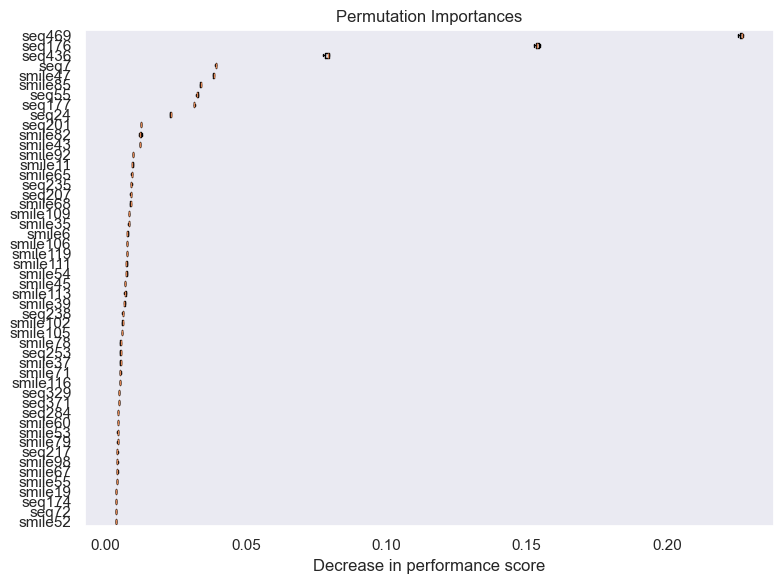

In [401]:
%%time
# Feature permutation importance: take 86 mins to run for 3 repeats, reduce repeat to 1
feat_perm_imp = permutation_importance(model, X_test, y_test, n_repeats=1, random_state=rand_state, n_jobs=1)

sorted_importances_idx = feat_perm_imp.importances_mean.argsort()
importances = pd.DataFrame(
    feat_perm_imp.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

fig, ax = plt.subplots(figsize=(8,6))
plt.grid()

## limit to top 50 feature if too many features
top = 50
if importances.shape[1] > top:
    ax.boxplot(importances.iloc[:, -top:], vert=False, labels=importances.columns[-top:])
else:
    ax.boxplot(importances, vert=False, labels=importances.columns);

ax.set_title("Permutation Importances")
ax.set_xlabel("Decrease in performance score")
ax.figure.tight_layout()

#### Model tuning and cross validation
tuning is a must to reduce over-fitting, it took a long time on my PC

In [ ]:
%%time

## randomforest
ml_model = RandomForestRegressor(random_state=42)
model_name = 'Random Forest'

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [11, 19],
}

# Define cross-validation objects for the inner and outer loops of the nested cross-validation
# for continous variable, can't use StratifiedKFold
cv_inner = 3
cv_outer = 5

## score: neg_mean_squared_error
search = GridSearchCV(ml_model, param_grid, scoring='neg_mean_squared_error', cv=cv_inner, return_train_score=True)
scores = cross_validate(search, X_train, y_train, scoring='neg_mean_squared_error', cv=cv_outer, return_train_score=True, return_estimator=True)

print('-------------------------------------------------------------')
print('Model: {}'.format(model_name))
print('Mean training nMSE {}, std. dev. {}'.format(round(scores['train_score'].mean(), 3), round(scores['train_score'].std(), 3)))
print('Mean test nMSE {}, std. dev. {}'.format(round(scores['test_score'].mean(), 3), round(scores['test_score'].std(), 3)))

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

### 3.2 XGboost Model
tuning:
1. the number of trees
2. the maximum depth of each tree
3. the learning rate (often set to small values such 0.1, 0.01)
4. the subsample which is the number of the data samples used in each tree
5. colsample_bytree which is the number of features used in each tree, set to a value of 1 when using all features.

In [419]:
%%time

xgb = xgboost.XGBRegressor(n_estimators = 500, 
                           random_state = 42, 
                           max_depth=15)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)

CPU times: total: 2h 4min 40s
Wall time: 8min 19s


In [429]:
print("For training data:")
regression_report(y_train, y_train_pred)

print("For testing data:")
regression_report(y_test, y_pred)

For training data:
Metrics for regression:
      mean absolute error:                0.410
    median absolute error:                0.010
       mean squared error:                0.997
                max error:               10.589
                 r2 score:                0.914

Percentiles of error (y_true - y_pred):
                        5:               -1.414
                       25:               -0.010
                       50:               -0.000
                       75:                0.009
                       95:                1.436
For testing data:
Metrics for regression:
      mean absolute error:                1.626
    median absolute error:                1.150
       mean squared error:                5.174
                max error:               14.297
                 r2 score:                0.556

Percentiles of error (y_true - y_pred):
                        5:               -3.794
                       25:               -1.037
                 

In [442]:
filename = mod_dir + 'multi_interaction_XGB_model.pkl'
pickle.dump(model, open(filename, 'wb'))

## 5. Running on test data
assuming test data is in the same format as input data, a example test file is inlcuded

#### 5.1 Load data file, assuming no cleaning up needed here, only 2 columns with protein ID and chem ID

In [34]:
sample_df = pd.read_csv(dat_dir + "test.csv")

## convert pubchem_cid to integer as query with float won't work
sample_df['pubchem_cid'] = sample_df['pubchem_cid'].astype(int)
sample_df

,UniProt_ID,pubchem_cid
0,A0A0B4J268,7428
1,A0A0B4J268,65303


#### 5.2 Prepare data, add embedding

In [43]:
## get protein sequence and embedding
protein_df = get_uniprot_data(sample_df['UniProt_ID'].unique().tolist())
protein_df['seq_embed'] = get_protein_embedding(protein_df['Seq'].tolist())

print(protein_df.shape)
#display(protein_df.head())

## somehow, use UniProt_ID as index makes other columns NA? so set it as index first
protein_df.set_index('UniProt_ID', inplace=True)
prot_embed_df = pd.DataFrame(protein_df['seq_embed'].tolist(), index=protein_df.index)
prot_embed_df = prot_embed_df.add_prefix('seq')
print(prot_embed_df.shape)
prot_embed_df.head()

Using cache found in C:\Users\cloud/.cache\torch\hub\facebookresearch_esm_main


Get embedding for 1 sequences with encoder: <protenc.encoder.ProteinEncoder object at 0x000002A208E2AF50>
(109, 480)
(1, 5)
(1, 480)


,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8,seq9,...,seq470,seq471,seq472,seq473,seq474,seq475,seq476,seq477,seq478,seq479
UniProt_ID,,,,,,,,,,,,,,,,,,,,,
A0A0B4J268,-0.037681,0.156351,0.02371,0.219032,0.059007,-0.037374,-0.15912,0.1943,0.066875,0.008405,...,-0.016463,-0.123053,-0.007845,-0.012806,-0.132463,-0.148598,0.131442,0.038125,-0.057234,0.151593


In [45]:
## get compound smile and embedding
chem_df = get_pubchem_data(sample_df['pubchem_cid'].unique().tolist())
chem_df['comp_embed'] = get_compound_embedding(chem_df['IsomericSMILES'])

print(chem_df.shape)
#display(chem_df.head())

## compound embedding
chem_embed_df = pd.DataFrame(chem_df['comp_embed'].tolist(), index=chem_df.index)
chem_embed_df = chem_embed_df.add_prefix('smile')
print(chem_embed_df.shape)
chem_embed_df.head(2)

(2, 8)
(2, 128)


,smile0,smile1,smile2,smile3,smile4,smile5,smile6,smile7,smile8,smile9,...,smile118,smile119,smile120,smile121,smile122,smile123,smile124,smile125,smile126,smile127
CID,,,,,,,,,,,,,,,,,,,,,
7428,0,1,1,0,0,0,0,0,1,1,...,1,0,1,0,0,0,1,0,1,0
65303,0,1,1,1,0,0,1,0,1,1,...,0,0,1,1,0,1,1,1,1,1


In [47]:
## integrate 2 embedding data sets
## can't join as some keys are 
print(sample_df.shape)

test_df = sample_df.merge(prot_embed_df, left_on = 'UniProt_ID', right_index = True, how='inner')
print(test_df.shape)

test_df = test_df.merge(chem_embed_df, left_on = 'pubchem_cid', right_index = True, how='inner')
print(test_df.shape)

test_df.set_index(['UniProt_ID', 'pubchem_cid'], inplace=True)

print(test_df.shape)
test_df.head()

(2, 2)
(2, 482)
(2, 610)
(2, 608)


seq0      seq1     seq2      seq3      seq4  \
UniProt_ID pubchem_cid                                                    
A0A0B4J268 7428        -0.037681  0.156351  0.02371  0.219032  0.059007   
           65303       -0.037681  0.156351  0.02371  0.219032  0.059007   

                            seq5     seq6    seq7      seq8      seq9  ...  \
UniProt_ID pubchem_cid                                                 ...   
A0A0B4J268 7428        -0.037374 -0.15912  0.1943  0.066875  0.008405  ...   
           65303       -0.037374 -0.15912  0.1943  0.066875  0.008405  ...   

                        smile118  smile119  smile120  smile121  smile122  \
UniProt_ID pubchem_cid                                                     
A0A0B4J268 7428                1         0         1         0         0   
           65303               0         0         1         1         0   

                        smile123  smile124  smile125  smile126  smile127  
UniProt_ID pubchem_cid                                                    
A0A0B4J268 7428                0         1         0         1         0  
           65303               1         1         1         1         1  

[2 rows x 608 columns]

#### 5.3 Load save model

In [24]:
with open(mod_dir + 'multi_interaction_RF_model.pkl', 'rb') as f:
    model = pickle.load(f)

#### 5.4 Get prediction

In [49]:
sample_prediction = model.predict(test_df)
sample_prediction

array([8.63, 8.71])